# Electrofacies Classifier

In [ ]:
# ploting, dataframe, and numerical operation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotfunc import efplot_data, efplot_val, efplot_test

# dataset splitting
from sklearn.model_selection import train_test_split

# training
!pip install jcopml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import f1_score, classification_report

# evaluation
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_actual_vs_prediction

# feature engineering
from jcopml.feature_importance import mean_score_decrease as msd

## Data loading

In [ ]:
df = pd.read_csv("ef_train.csv")

df = df.replace([-999.25, df['GR'].max(), df['DTCO'].max(), df['NPHI'].max()], np.nan)

df.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Electrofacies
0,4600.0,P-2,Jamieson Fm,66.4510,3.8376,3.6067,13.8882,2.5715,81.8708,NaN,2
1,4600.5,P-2,Jamieson Fm,54.4524,4.5844,4.2673,12.1851,2.5604,78.5466,NaN,2
2,4601.0,P-2,Jamieson Fm,51.3234,4.9751,4.4704,12.0860,2.5458,81.6343,NaN,2
3,4601.5,P-2,Jamieson Fm,49.2121,5.1362,4.6478,11.5609,2.5479,78.2709,NaN,2
4,4602.0,P-2,Jamieson Fm,68.4992,4.3777,4.0461,15.9469,2.5307,79.5989,NaN,2


## Data statistics
- Target data label quite balanced

- Classification metrics = accuracy

In [ ]:
df.describe()

,Depth,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Electrofacies
count,2995.000000,2752.000000,2953.000000,2948.000000,2904.000000,2829.000000,2662.000000,2468.000000,2995.000000
mean,4962.672287,66.165314,43.498611,27.765264,20.951128,2.654081,68.837401,121.471750,2.491152
std,216.569096,35.172555,180.250196,74.263356,10.938193,0.119257,9.057644,22.403778,1.104209
min,4577.000000,5.377100,0.382200,0.106000,2.085300,1.525400,42.793000,69.261800,0.000000
25%,4775.500000,34.857950,4.396600,4.294575,11.536625,2.629200,62.437400,103.399550,2.000000
50%,4962.500000,65.585350,9.641000,9.460800,20.416250,2.674400,67.121050,117.314650,2.000000
75%,5149.750000,92.777125,25.361700,24.062525,27.414625,2.711300,75.129650,136.881475,4.000000
max,5351.000000,171.265700,1950.000000,1552.880400,57.603600,3.157100,122.791000,234.866500,4.000000


In [ ]:
df.Electrofacies.value_counts()

2    1073
4     810
1     620
3     485
0       7
Name: Electrofacies, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


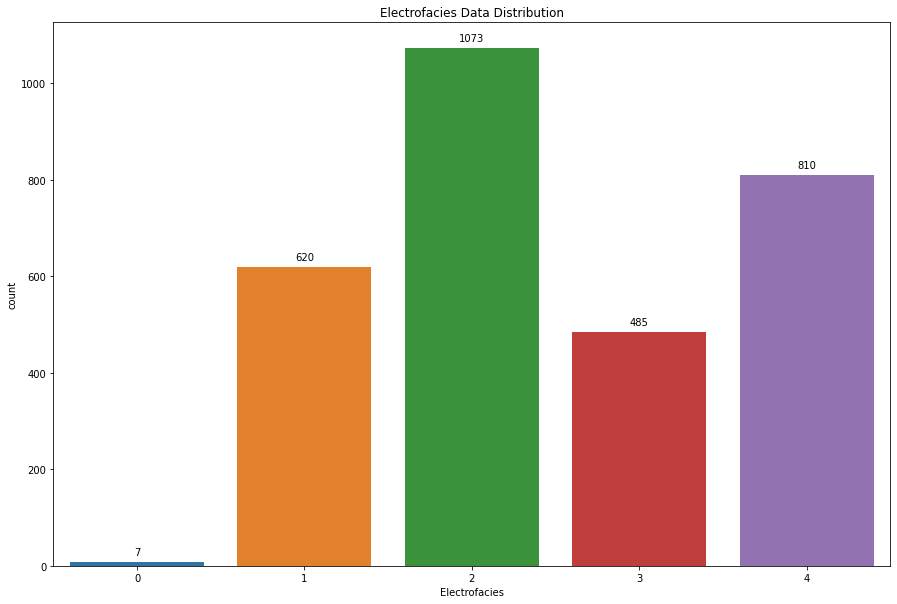

In [ ]:
plt.figure(figsize = (15, 10))

efplot = sns.countplot(df.Electrofacies);

for i in efplot.patches:
    efplot.annotate(format(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Electrofacies Data Distribution')

plt.savefig('ef_distribution.png')

plt.show()

## Missing values checking

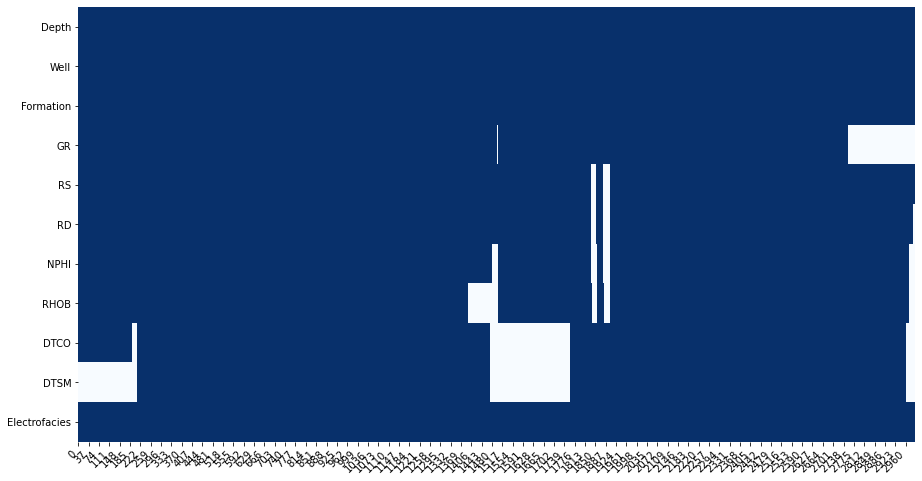

In [ ]:
plot_missing_value(df)

## Training data plotting

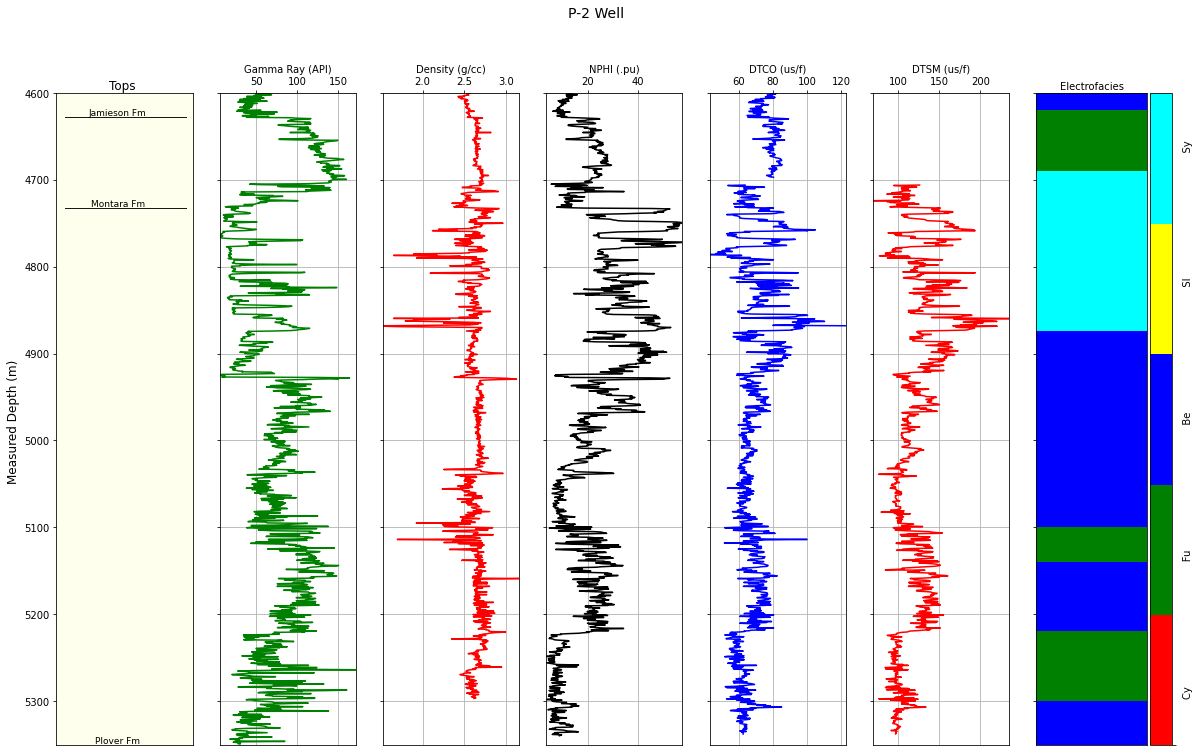

In [ ]:
efplot_data(df, 'P-2')

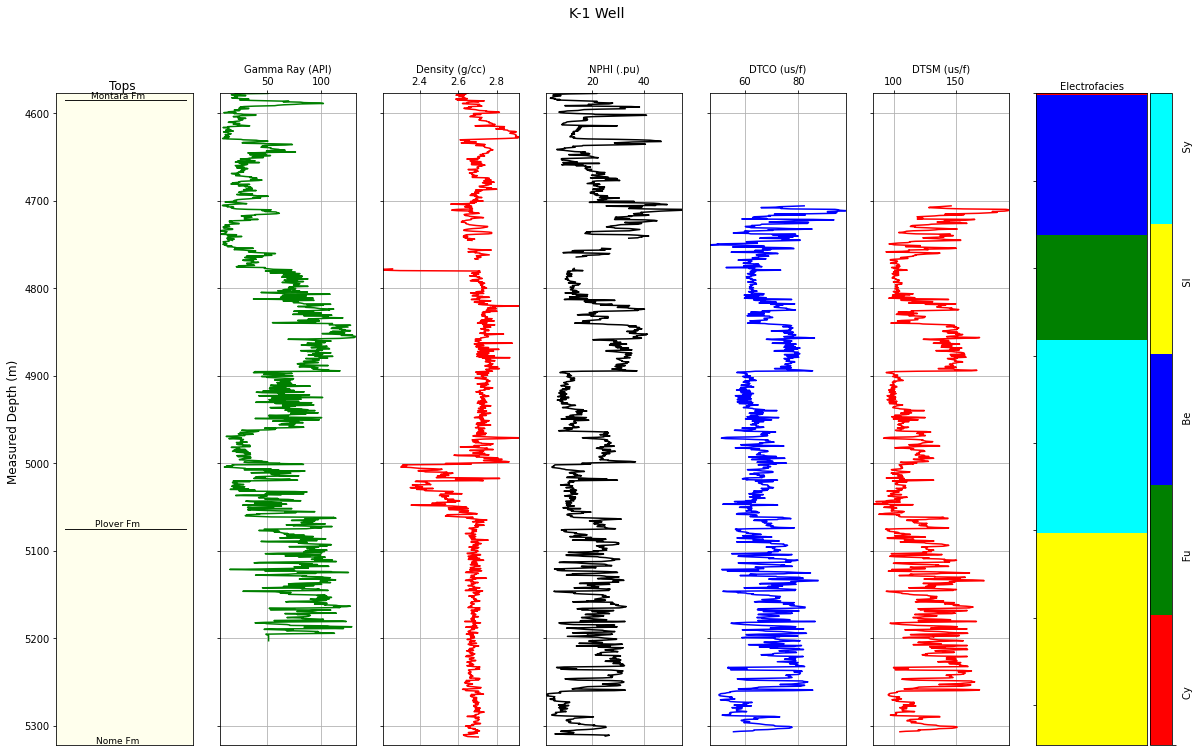

In [ ]:
efplot_data(df, 'K-1')

## Dataset splitting
- Testing GR logs as the only features to predict electrofacies pattern (model error)

- Testing GR logs and formation as the features to predict electrofacies pattern (model error)

In [ ]:
df.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM', 'Electrofacies'],
      dtype='object')

In [ ]:
X = df.drop(columns= ['Depth', 'Well', 'Formation', 'RS', 'Electrofacies'])
y = df.Electrofacies

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2396, 6), (599, 6), (2396,), (599,))

In [ ]:
X.columns

Index(['GR', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

In [ ]:
y

0       2
1       2
2       2
3       2
4       2
       ..
2990    3
2991    3
2992    3
2993    3
2994    3
Name: Electrofacies, Length: 2995, dtype: int64

## Training
- Using KNN, manual numerical_pipeline with simple imputer and standard scaler, 58.9%

- Using KNN, num_pipe, scaling standard, impute mean, GSCV, 76,8%, done - final

- Using KNN, num_pipe, scaling standard, impute mean, GSCV, features = ['GR', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], 77.8%

- Using KNN, num_pipe, scaling standard (auto), impute mean, transform yeo-johnson, GSCV, features = ['GR', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], 81% - final 

In [ ]:
X_train.columns

Index(['GR', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

In [ ]:
# algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# tuning and parameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(impute = 'mean', transform = 'yeo-johnson'), X_train.columns)
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   13.5s



{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.7967423451635351 0.8163606010016694


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   17.9s finished


### Tuning report

In [ ]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__n_neighbors,param_algo__p,param_algo__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.059770,0.004924,0.015595,0.000304,5,1,distance,"{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__...",0.802083,0.807933,0.787056,0.770355,0.816284,0.796742,0.016283,1
19,0.059415,0.004807,0.016543,0.000252,7,1,distance,"{'algo__n_neighbors': 7, 'algo__p': 1, 'algo__...",0.810417,0.801670,0.793319,0.766180,0.805846,0.795486,0.015697,2
29,0.056568,0.005962,0.012478,0.000500,9,2,distance,"{'algo__n_neighbors': 9, 'algo__p': 2, 'algo__...",0.806250,0.803758,0.772443,0.774530,0.805846,0.792565,0.015615,3
15,0.058757,0.006349,0.155086,0.003557,5,1.5,distance,"{'algo__n_neighbors': 5, 'algo__p': 1.5, 'algo...",0.797917,0.810021,0.791232,0.755741,0.805846,0.792151,0.019322,4
0,0.062692,0.004649,0.030227,0.000924,1,1,uniform,"{'algo__n_neighbors': 1, 'algo__p': 1, 'algo__...",0.808333,0.797495,0.801670,0.755741,0.793319,0.791312,0.018464,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.054998,0.005905,0.261953,0.002930,27,1.5,uniform,"{'algo__n_neighbors': 27, 'algo__p': 1.5, 'alg...",0.768750,0.718163,0.726514,0.722338,0.757829,0.738719,0.020528,86
76,0.057644,0.006025,0.035169,0.003561,25,2,uniform,"{'algo__n_neighbors': 25, 'algo__p': 2, 'algo_...",0.764583,0.732777,0.711900,0.726514,0.755741,0.738303,0.019295,87
86,0.065027,0.008254,0.277123,0.005225,29,1.5,uniform,"{'algo__n_neighbors': 29, 'algo__p': 1.5, 'alg...",0.768750,0.713987,0.728601,0.713987,0.753653,0.735796,0.021945,88
88,0.058767,0.008265,0.037689,0.002227,29,2,uniform,"{'algo__n_neighbors': 29, 'algo__p': 2, 'algo_...",0.764583,0.722338,0.720251,0.720251,0.747390,0.734963,0.018023,89


## Feature engineering

### Feature importance

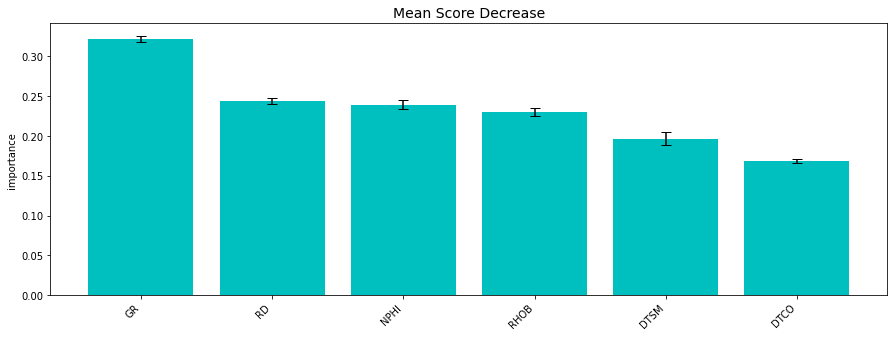

In [ ]:
df_fe = msd(X_train, y_train, model, plot = True, topk=7)

## Fine tuning

In [ ]:
# preprocessor
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(scaling= 'standard', poly = 2), X_train.columns.drop(['RS', 'RD']))
])

# final pipeline
pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# tuning
model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv= 5, n_iter = 50, 
                           n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.8min finished



{'algo__max_depth': 46, 'algo__max_features': 0.7683398923949077, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 136, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9991652754590985 0.7595911621433542 0.7395659432387313


## Prediction

### Predict training data

In [ ]:
df['Ef_pred'] = model.predict(X)

df.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Electrofacies,Ef_pred
0,4600.0,P-2,Jamieson Fm,66.4510,3.8376,3.6067,13.8882,2.5715,81.8708,NaN,2,2
1,4600.5,P-2,Jamieson Fm,54.4524,4.5844,4.2673,12.1851,2.5604,78.5466,NaN,2,2
2,4601.0,P-2,Jamieson Fm,51.3234,4.9751,4.4704,12.0860,2.5458,81.6343,NaN,2,2
3,4601.5,P-2,Jamieson Fm,49.2121,5.1362,4.6478,11.5609,2.5479,78.2709,NaN,2,2
4,4602.0,P-2,Jamieson Fm,68.4992,4.3777,4.0461,15.9469,2.5307,79.5989,NaN,2,2


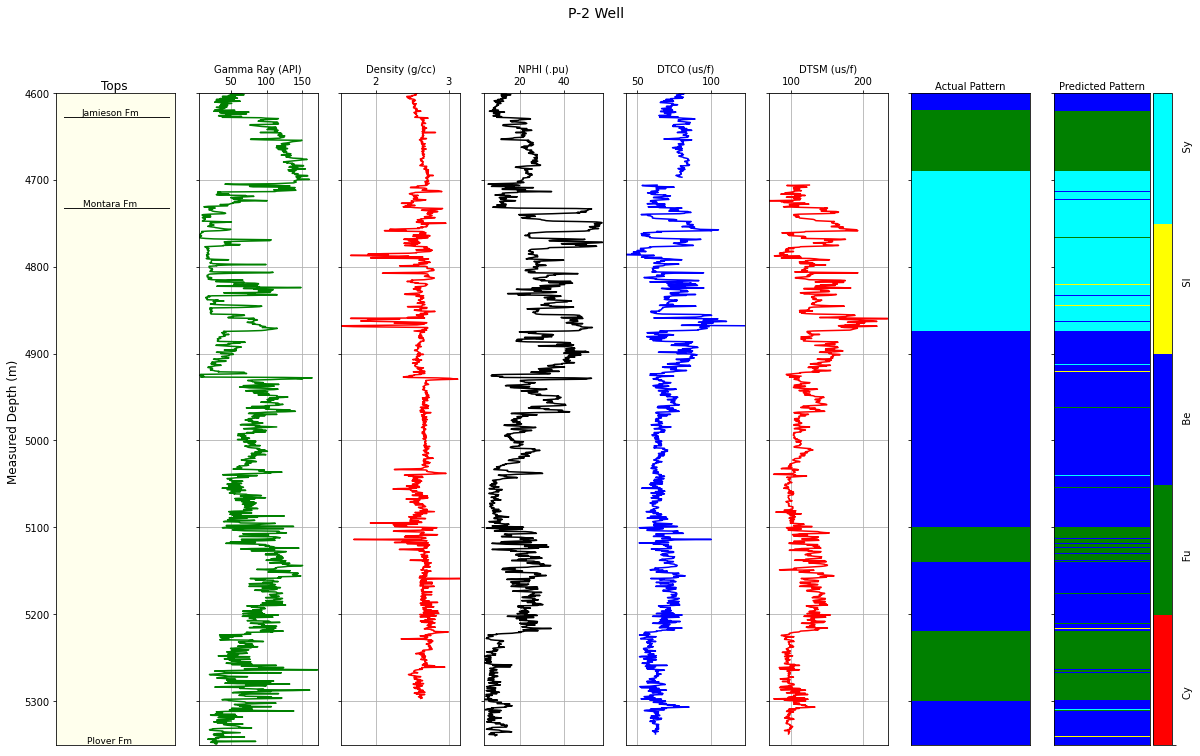

In [ ]:
efplot_val(df, 'P-2')

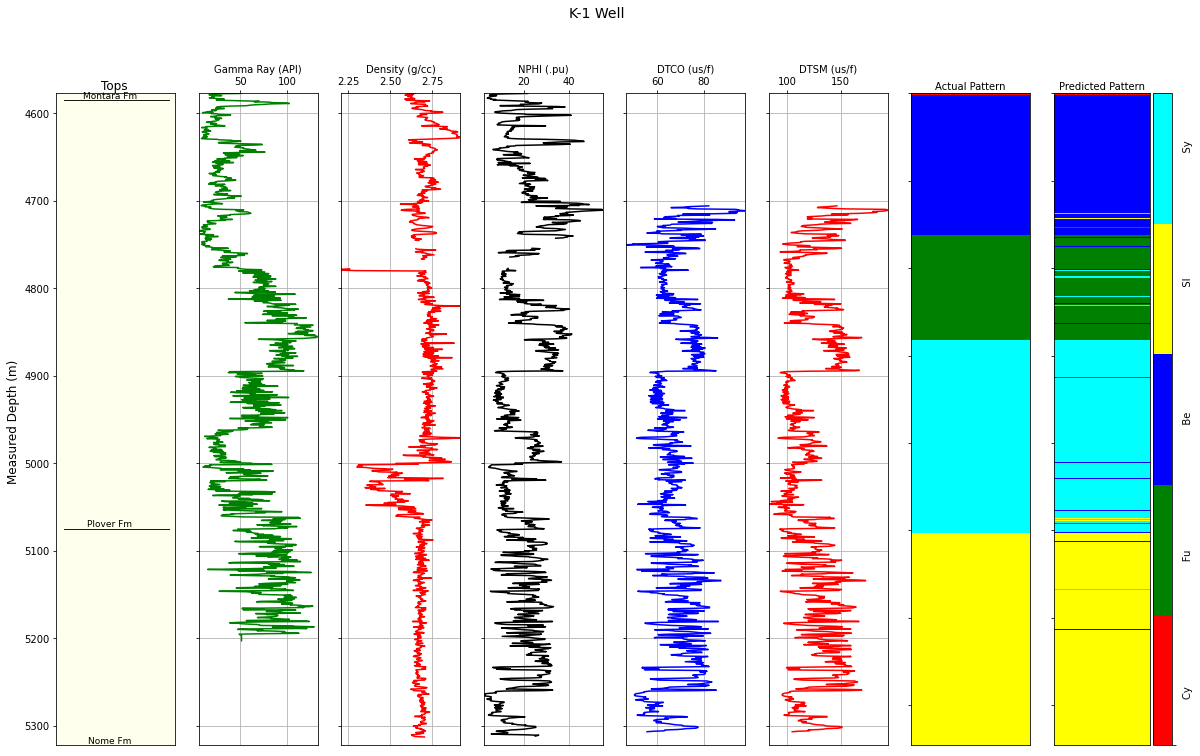

In [ ]:
efplot_val(df, 'K-1')

In [ ]:
# classification report
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       858
           3       1.00      1.00      1.00       388
           4       1.00      1.00      1.00       648

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396


Test report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.65      0.71       124
           2       0.77      0.90      0.83       215
           3       0.86      0.89      0.87        97
           4       0.87      0.80      0.83       162

    accuracy                           0.82       599
   macro avg       0.66      0.65      0.65       599
weighted avg       0.82      0.82      0.81       5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


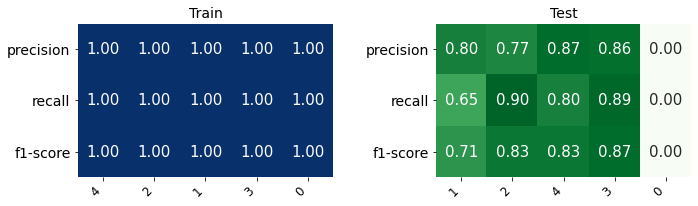

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

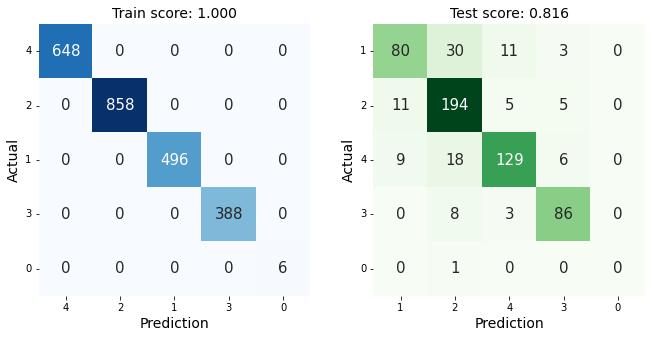

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### Predict testing data

In [ ]:
df_test = pd.read_csv('boreas.csv')

df_test = df_test.replace([-999.25], np.nan)

df_test = df_test.replace([df_test['GR'].nlargest(3)], np.nan)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN


In [ ]:
df_test.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM'],
      dtype='object')

In [ ]:
X_test = pd.DataFrame(df_test.drop(columns= ['Depth', 'Well', 'Formation', 'RS']))

X_test.head()

,GR,RD,NPHI,RHOB,DTCO,DTSM
0,55.3259,1.4170,12.04,2.6282,87.4786,NaN
1,61.7744,1.0694,18.93,2.6688,93.8623,NaN
2,60.9437,1.1022,20.12,2.6014,78.9452,NaN
3,67.9765,1.2345,20.01,2.6130,64.5839,NaN
4,86.1773,1.0360,21.62,2.6041,69.4141,NaN


In [ ]:
df_test['Ef_pred'] = model.predict(X_test)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,2
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,1
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,1
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,3
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,3


In [ ]:
df_test.to_csv()

',Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred\n0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4169999999999998,12.04,2.6282,87.4786,,2\n1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,,1\n2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,,1\n3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.613,64.5839,,3\n4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.036,21.62,2.6041,69.4141,,3\n5,4612.5,B-1,Echuca Shoals Fm,80.2059,1.3382,1.3263,21.89,2.6021,73.5985,,1\n6,4613.0,B-1,Echuca Shoals Fm,74.5949,1.6413,1.5482,21.34,2.6164,69.8498,,3\n7,4613.5,B-1,Echuca Shoals Fm,78.5921,1.3767,1.3519999999999999,21.31,2.6413,91.6138,,1\n8,4614.0,B-1,Echuca Shoals Fm,83.1176,1.5030000000000001,1.4596,20.82,2.6017,85.3235,,1\n9,4614.5,B-1,Echuca Shoals Fm,51.7665,1.3676,1.3686,20.89,2.5649,88.2898,,1\n10,4615.0,B-1,Echuca Shoals Fm,41.7301,3.7995,3.6336,17.08,2.6257,87.7482,,2\n11,4615.5,B-1,Echuca Shoals Fm,34.8966,7.9456,7.6302,12.8

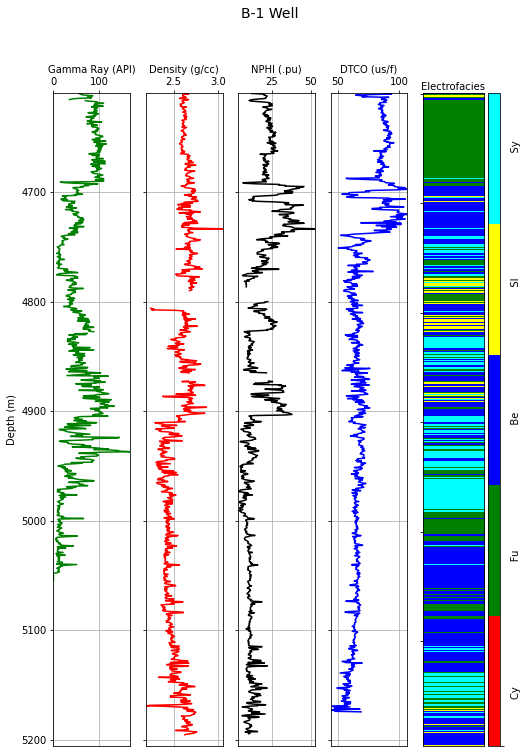

In [ ]:
efplot_test(df_test, 'B-1')

## Save ML model

In [ ]:
save_model(model.best_estimator_, "__________.pkl")

Model is pickled as model/__________.pkl
